In [136]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
#import missingno as mno

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel,T
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [137]:
df = pd.read_csv("C:\\Users\\bduser\\Desktop\\Harsh_Thesis_work\\Bitcoin_price_with_sentiments.csv")

In [138]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [139]:
df['Price'] = df['Price'].str.replace(',','')
df['Price'] = df['Price'].astype('float')

df['Open'] = df['Open'].str.replace(',','')
df['Open'] = df['Open'].astype('float')

df['High'] = df['High'].str.replace(',','')
df['High'] = df['High'].astype('float')

df['Low'] = df['Low'].str.replace(',','')
df['Low'] = df['Low'].astype('float')


df['Vol.'] = df['Vol.'].astype(str)
for i in range(len(df['Vol.'])):
    if "K" in df['Vol.'][i]:
        df['Vol.'][i] = df['Vol.'][i].replace("K","")
        df['Vol.'][i] = float(df['Vol.'][i])
        df['Vol.'][i] =df['Vol.'][i]*1000

    elif "M" in df['Vol.'][i]:
        df['Vol.'][i] = df['Vol.'][i].replace("M","")
        df['Vol.'][i] = float(df['Vol.'][i])
        df['Vol.'][i] = df['Vol.'][i]*1000000

df['Vol.'] = df['Vol.'].astype(float)

df["Change %"] = df["Change %"].astype(str)
for i in range(len(df["Change %"])):
        df["Change %"][i] = df["Change %"][i].replace("%","")
df["Change %"] = df["Change %"].astype(float)

df['Date'] = pd.to_datetime(df['Date'])

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              692 non-null    datetime64[ns]
 1   Price             692 non-null    float64       
 2   Open              692 non-null    float64       
 3   High              692 non-null    float64       
 4   Low               692 non-null    float64       
 5   Vol.              692 non-null    float64       
 6   Change %          692 non-null    float64       
 7   sentiment_scores  692 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 43.4 KB


In [141]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,sentiment_scores
0,2019-11-23,"7,324.10","7,271.60","7,342.50","7,093.70","783,180.00",0.71,0.14
1,2019-11-22,"7,272.50","7,627.90","7,700.90","6,818.50","1,410,000.00",-4.66,0.12
2,2019-11-21,"7,627.90","8,099.40","8,129.60","7,519.70","891,500.00",-5.82,0.13
3,2019-11-20,"8,099.30","8,145.70","8,223.00","8,074.20","607,270.00",-0.57,0.16
4,2019-11-19,"8,145.70","8,207.70","8,245.60","8,032.80","654,270.00",-0.76,0.14


In [142]:
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = "\_NBEATS_model_03.pth.tar"   # file name to save the model under

EPOCHS = 200
INLEN = 32          # input size
BLOCKS = 64         
LWIDTH = 32
BATCH = 64          # batch size
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (10, 10)

qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

#mpath = os.path.abspath(os.getcwd()) + SAVE     # path and file name to save the model

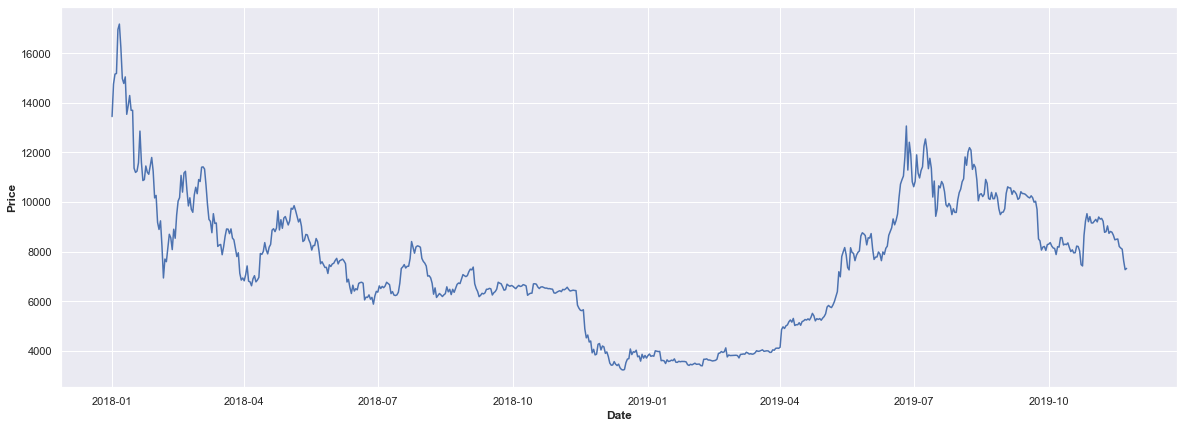

In [143]:
plt.figure(100, figsize=(20, 7))
sns.lineplot(x = "Date", y = "Price", data = df, palette="coolwarm");

<AxesSubplot:>

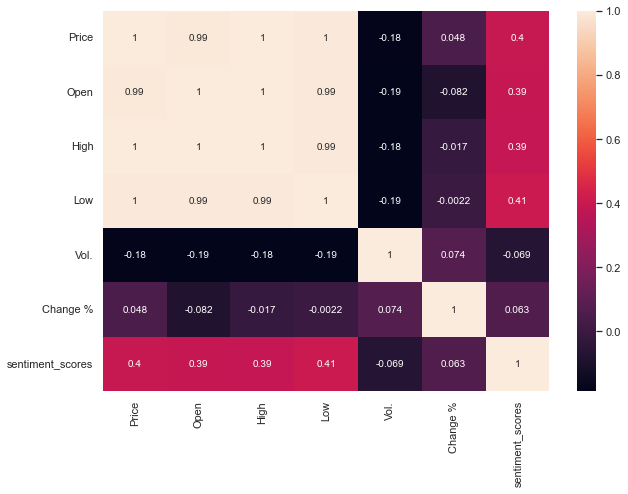

In [144]:
#calculating corrleation
df_corr = df.corr()

plt.figure(figsize=(10,7))
sns.heatmap(df_corr,annot=True)

In [145]:
df2 = df.copy()

In [146]:
df2['month'] = pd.DatetimeIndex(df2['Date']).month

df2["wday"] = pd.DatetimeIndex(df2['Date']).dayofweek
dict_days = {0:"1_Mon", 1:"2_Tue", 2:"3_Wed", 3:"4_Thu", 4:"5_Fri", 5:"6_Sat", 6:"7_Sun"}
df2["weekday"] = df2["wday"].apply(lambda x: dict_days[x])

In [147]:
df2

,Date,Price,Open,High,Low,Vol.,Change %,sentiment_scores,month,wday,weekday
0,2019-11-23,"7,324.10","7,271.60","7,342.50","7,093.70","783,180.00",0.71,0.14,11,5,6_Sat
1,2019-11-22,"7,272.50","7,627.90","7,700.90","6,818.50","1,410,000.00",-4.66,0.12,11,4,5_Fri
2,2019-11-21,"7,627.90","8,099.40","8,129.60","7,519.70","891,500.00",-5.82,0.13,11,3,4_Thu
3,2019-11-20,"8,099.30","8,145.70","8,223.00","8,074.20","607,270.00",-0.57,0.16,11,2,3_Wed
4,2019-11-19,"8,145.70","8,207.70","8,245.60","8,032.80","654,270.00",-0.76,0.14,11,1,2_Tue
...,...,...,...,...,...,...,...,...,...,...,...
687,2018-01-05,"16,954.80","15,180.10","17,126.90","14,832.40","141,960.00",11.69,0.05,1,4,5_Fri
688,2018-01-04,"15,180.10","15,156.50","15,408.70","14,244.70","110,970.00",0.15,0.06,1,3,4_Thu
689,2018-01-03,"15,156.60","14,754.10","15,435.00","14,579.70","106,540.00",2.73,0.04,1,2,3_Wed
690,2018-01-02,"14,754.10","13,444.90","15,306.10","12,934.20","137,730.00",9.74,0.06,1,1,2_Tue


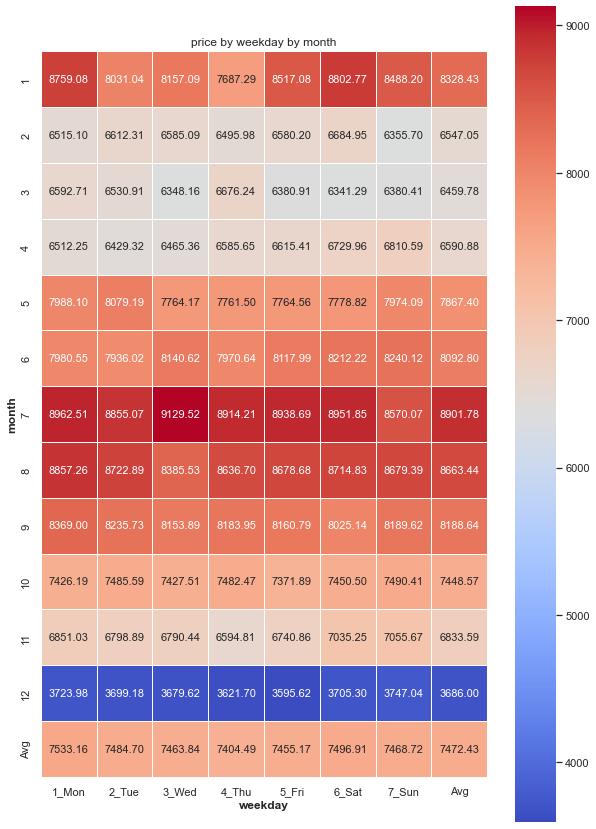

In [125]:
# pivot table: weekdays in months
piv = pd.pivot_table(   df2, 
                        values="Price", 
                        index="month", 
                        columns="weekday", 
                        aggfunc="mean", 
                        margins=True, margins_name="Avg", 
                        fill_value=0)
pd.options.display.float_format = '{:,.2f}'.format

plt.figure(figsize = (10,15))
sns.set(font_scale=1)
sns.heatmap(piv.round(3), annot=True, square = True, \
            linewidths=.75, cmap="coolwarm", fmt = ".2f", annot_kws = {"size": 11})
plt.title("price by weekday by month")
plt.show()

In [126]:
df

,Date,Price,Open,High,Low,Vol.,Change %,sentiment_scores
0,2019-11-23,"7,324.10","7,271.60","7,342.50","7,093.70","783,180.00",0.71,0.14
1,2019-11-22,"7,272.50","7,627.90","7,700.90","6,818.50","1,410,000.00",-4.66,0.12
2,2019-11-21,"7,627.90","8,099.40","8,129.60","7,519.70","891,500.00",-5.82,0.13
3,2019-11-20,"8,099.30","8,145.70","8,223.00","8,074.20","607,270.00",-0.57,0.16
4,2019-11-19,"8,145.70","8,207.70","8,245.60","8,032.80","654,270.00",-0.76,0.14
...,...,...,...,...,...,...,...,...
687,2018-01-05,"16,954.80","15,180.10","17,126.90","14,832.40","141,960.00",11.69,0.05
688,2018-01-04,"15,180.10","15,156.50","15,408.70","14,244.70","110,970.00",0.15,0.06
689,2018-01-03,"15,156.60","14,754.10","15,435.00","14,579.70","106,540.00",2.73,0.04
690,2018-01-02,"14,754.10","13,444.90","15,306.10","12,934.20","137,730.00",9.74,0.06


In [127]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Price"])

In [195]:
print(type(ts_P))

<class 'darts.timeseries.TimeSeries'>


In [148]:
# create time series object for the feature columns
df_3 = df.drop(['Price'],axis=1)
ts_covF = TimeSeries.from_dataframe(df_3,"Date")

In [149]:
# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['Open', 'High', 'Low', 'Vol.', 'Change %', 'sentiment_scores'], dtype='object', name='component')
duration: 691 days 00:00:00
frequency: <Day>
frequency: D
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [135]:
df_3

,Date,Open,High,Low,Vol.,Change %,sentiment_scores
time,,,,,,,
0,2019-11-23,"7,271.60","7,342.50","7,093.70","783,180.00",0.71,0.14
1,2019-11-22,"7,627.90","7,700.90","6,818.50","1,410,000.00",-4.66,0.12
2,2019-11-21,"8,099.40","8,129.60","7,519.70","891,500.00",-5.82,0.13
3,2019-11-20,"8,145.70","8,223.00","8,074.20","607,270.00",-0.57,0.16
4,2019-11-19,"8,207.70","8,245.60","8,032.80","654,270.00",-0.76,0.14
...,...,...,...,...,...,...,...
687,2018-01-05,"15,180.10","17,126.90","14,832.40","141,960.00",11.69,0.05
688,2018-01-04,"15,156.50","15,408.70","14,244.70","110,970.00",0.15,0.06
689,2018-01-03,"14,754.10","15,435.00","14,579.70","106,540.00",2.73,0.04


In [150]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(692, 6, 1)

In [151]:
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [152]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(SPLIT)
print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled price time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 0
training end: 621
training duration: 621
test start: 622
test end: 691
test duration: 69
first and last row of scaled price time series:


component,Price
time,
0,0.42
691,1.04


In [153]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(SPLIT)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,Open,High,Low,Vol.,Change %,sentiment_scores
Date,,,,,,
2018-01-01,0.76,0.76,0.74,0.00,0.41,0.35
2019-11-23,0.29,0.29,0.30,0.05,0.52,0.87


In [162]:
model = NBEATSModel(    input_chunk_length=INLEN,
                        output_chunk_length=N_FC, 
                        num_stacks=BLOCKS,
                        layer_widths=LWIDTH,
                        batch_size=BATCH,
                        n_epochs=EPOCHS,
                        nr_epochs_val_period=VALWAIT, 
                        likelihood=QuantileRegression(QUANTILES), 
                        optimizer_kwargs={"lr": LEARN}, 
                        model_name="NBEATS_EnergyES",
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=RAND,
                        force_reset=True,
                        save_checkpoints=True
                    )

In [163]:
# training: load a saved model or (re)train
model.fit(  series=ts_ttrain,  
                val_series=ts_ttest,  
                verbose=True)

Epoch 0:  91%|█████████ | 10/11 [00:00<00:00, 13.07it/s, loss=2.56, v_num=logs, train_loss=0.914]
Validating: 0it [00:00, ?it/s]
Epoch 1:  91%|█████████ | 10/11 [00:00<00:00, 14.11it/s, loss=1.58, v_num=logs, train_loss=0.471, val_loss=0.637]
Validating: 0it [00:00, ?it/s]
Epoch 2:  91%|█████████ | 10/11 [00:00<00:00, 14.21it/s, loss=0.518, v_num=logs, train_loss=0.351, val_loss=0.736]
Validating: 0it [00:00, ?it/s]
Epoch 3:  91%|█████████ | 10/11 [00:00<00:00, 13.81it/s, loss=0.336, v_num=logs, train_loss=0.200, val_loss=0.669]
Validating: 0it [00:00, ?it/s]
Epoch 4:  91%|█████████ | 10/11 [00:00<00:00, 14.15it/s, loss=0.216, v_num=logs, train_loss=0.154, val_loss=0.653]
Validating: 0it [00:00, ?it/s]
Epoch 5:  91%|█████████ | 10/11 [00:00<00:00, 13.89it/s, loss=0.174, v_num=logs, train_loss=0.111, val_loss=0.639]
Validating: 0it [00:00, ?it/s]
Epoch 6:  91%|█████████ | 10/11 [00:00<00:00, 13.90it/s, loss=0.149, v_num=logs, train_loss=0.133, val_loss=0.469]
Validating: 0it [00:00, ?it

Epoch 31:  91%|█████████ | 10/11 [00:00<00:00, 13.52it/s, loss=0.0724, v_num=logs, train_loss=0.0606, val_loss=0.242]
Validating: 0it [00:00, ?it/s]
Epoch 32:  91%|█████████ | 10/11 [00:00<00:00, 13.58it/s, loss=0.0675, v_num=logs, train_loss=0.0719, val_loss=0.234]
Validating: 0it [00:00, ?it/s]
Epoch 33:  91%|█████████ | 10/11 [00:00<00:00, 14.07it/s, loss=0.0727, v_num=logs, train_loss=0.0831, val_loss=0.264]
Validating: 0it [00:00, ?it/s]
Epoch 34:  91%|█████████ | 10/11 [00:00<00:00, 13.05it/s, loss=0.0774, v_num=logs, train_loss=0.0779, val_loss=0.276]
Validating: 0it [00:00, ?it/s]
Epoch 35:  91%|█████████ | 10/11 [00:00<00:00, 13.27it/s, loss=0.0865, v_num=logs, train_loss=0.0894, val_loss=0.434]
Validating: 0it [00:00, ?it/s]
Epoch 36:  91%|█████████ | 10/11 [00:00<00:00, 13.73it/s, loss=0.0857, v_num=logs, train_loss=0.0557, val_loss=0.271]
Validating: 0it [00:00, ?it/s]
Epoch 37:  91%|█████████ | 10/11 [00:00<00:00, 13.80it/s, loss=0.0723, v_num=logs, train_loss=0.0498, val_

Epoch 61:  91%|█████████ | 10/11 [00:00<00:00, 13.62it/s, loss=0.0678, v_num=logs, train_loss=0.0537, val_loss=0.242]
Validating: 0it [00:00, ?it/s]
Epoch 62:  91%|█████████ | 10/11 [00:00<00:00, 13.51it/s, loss=0.0627, v_num=logs, train_loss=0.0673, val_loss=0.276]
Validating: 0it [00:00, ?it/s]
Epoch 63:  91%|█████████ | 10/11 [00:00<00:00, 13.29it/s, loss=0.0575, v_num=logs, train_loss=0.0479, val_loss=0.294]
Validating: 0it [00:00, ?it/s]
Epoch 64:  91%|█████████ | 10/11 [00:00<00:00, 13.32it/s, loss=0.072, v_num=logs, train_loss=0.070, val_loss=0.251]  
Validating: 0it [00:00, ?it/s]
Epoch 65:  91%|█████████ | 10/11 [00:00<00:00, 13.62it/s, loss=0.0816, v_num=logs, train_loss=0.0898, val_loss=0.318]
Validating: 0it [00:00, ?it/s]
Epoch 66:  91%|█████████ | 10/11 [00:00<00:00, 13.56it/s, loss=0.0787, v_num=logs, train_loss=0.0944, val_loss=0.257]
Validating: 0it [00:00, ?it/s]
Epoch 67:  91%|█████████ | 10/11 [00:00<00:00, 13.42it/s, loss=0.081, v_num=logs, train_loss=0.0801, val_l

Epoch 91:  91%|█████████ | 10/11 [00:00<00:00, 13.40it/s, loss=0.0578, v_num=logs, train_loss=0.0585, val_loss=0.249]
Validating: 0it [00:00, ?it/s]
Epoch 92:  91%|█████████ | 10/11 [00:00<00:00, 13.12it/s, loss=0.0595, v_num=logs, train_loss=0.0414, val_loss=0.293]
Validating: 0it [00:00, ?it/s]
Epoch 93:  91%|█████████ | 10/11 [00:00<00:00, 13.38it/s, loss=0.0568, v_num=logs, train_loss=0.0484, val_loss=0.311]
Validating: 0it [00:00, ?it/s]
Epoch 94:  91%|█████████ | 10/11 [00:00<00:00, 13.08it/s, loss=0.0601, v_num=logs, train_loss=0.0704, val_loss=0.287]
Validating: 0it [00:00, ?it/s]
Epoch 95:  91%|█████████ | 10/11 [00:00<00:00, 13.35it/s, loss=0.0619, v_num=logs, train_loss=0.0469, val_loss=0.266]
Validating: 0it [00:00, ?it/s]
Epoch 96:  91%|█████████ | 10/11 [00:00<00:00, 13.52it/s, loss=0.0563, v_num=logs, train_loss=0.0393, val_loss=0.319]
Validating: 0it [00:00, ?it/s]
Epoch 97:  91%|█████████ | 10/11 [00:00<00:00, 13.51it/s, loss=0.0602, v_num=logs, train_loss=0.045, val_l

Epoch 121:  91%|█████████ | 10/11 [00:00<00:00, 13.20it/s, loss=0.0586, v_num=logs, train_loss=0.0631, val_loss=0.213]
Validating: 0it [00:00, ?it/s]
Epoch 122:  91%|█████████ | 10/11 [00:00<00:00, 12.66it/s, loss=0.0575, v_num=logs, train_loss=0.0454, val_loss=0.217]
Validating: 0it [00:00, ?it/s]
Epoch 123:  91%|█████████ | 10/11 [00:00<00:00, 13.55it/s, loss=0.0485, v_num=logs, train_loss=0.0404, val_loss=0.310]
Validating: 0it [00:00, ?it/s]
Epoch 124:  91%|█████████ | 10/11 [00:00<00:00, 13.53it/s, loss=0.0496, v_num=logs, train_loss=0.0544, val_loss=0.282]
Validating: 0it [00:00, ?it/s]
Epoch 125:  91%|█████████ | 10/11 [00:00<00:00, 13.35it/s, loss=0.0555, v_num=logs, train_loss=0.0648, val_loss=0.287]
Validating: 0it [00:00, ?it/s]
Epoch 126:  91%|█████████ | 10/11 [00:00<00:00, 12.95it/s, loss=0.0584, v_num=logs, train_loss=0.103, val_loss=0.310] 
Validating: 0it [00:00, ?it/s]
Epoch 127:  91%|█████████ | 10/11 [00:00<00:00, 12.77it/s, loss=0.0604, v_num=logs, train_loss=0.046

Epoch 151:  91%|█████████ | 10/11 [00:00<00:00, 13.24it/s, loss=0.0517, v_num=logs, train_loss=0.0503, val_loss=0.332]
Validating: 0it [00:00, ?it/s]
Epoch 152:  91%|█████████ | 10/11 [00:00<00:00, 13.35it/s, loss=0.0585, v_num=logs, train_loss=0.0505, val_loss=0.299]
Validating: 0it [00:00, ?it/s]
Epoch 153:  91%|█████████ | 10/11 [00:00<00:00, 13.21it/s, loss=0.0649, v_num=logs, train_loss=0.0544, val_loss=0.336]
Validating: 0it [00:00, ?it/s]
Epoch 154:  91%|█████████ | 10/11 [00:00<00:00, 13.35it/s, loss=0.0597, v_num=logs, train_loss=0.0657, val_loss=0.285]
Validating: 0it [00:00, ?it/s]
Epoch 155:  91%|█████████ | 10/11 [00:00<00:00, 13.59it/s, loss=0.051, v_num=logs, train_loss=0.0691, val_loss=0.233] 
Validating: 0it [00:00, ?it/s]
Epoch 156:  91%|█████████ | 10/11 [00:00<00:00, 13.15it/s, loss=0.0487, v_num=logs, train_loss=0.0459, val_loss=0.231]
Validating: 0it [00:00, ?it/s]
Epoch 157:  91%|█████████ | 10/11 [00:00<00:00, 12.80it/s, loss=0.0543, v_num=logs, train_loss=0.038

Epoch 181:  91%|█████████ | 10/11 [00:00<00:00, 13.58it/s, loss=0.0651, v_num=logs, train_loss=0.0857, val_loss=0.238]
Validating: 0it [00:00, ?it/s]
Epoch 182:  91%|█████████ | 10/11 [00:00<00:00, 14.05it/s, loss=0.0605, v_num=logs, train_loss=0.0458, val_loss=0.235]
Validating: 0it [00:00, ?it/s]
Epoch 183:  91%|█████████ | 10/11 [00:00<00:00, 13.25it/s, loss=0.0537, v_num=logs, train_loss=0.0454, val_loss=0.257]
Validating: 0it [00:00, ?it/s]
Epoch 184:  91%|█████████ | 10/11 [00:00<00:00, 13.28it/s, loss=0.0569, v_num=logs, train_loss=0.083, val_loss=0.359] 
Validating: 0it [00:00, ?it/s]
Epoch 185:  91%|█████████ | 10/11 [00:00<00:00, 13.53it/s, loss=0.0589, v_num=logs, train_loss=0.0482, val_loss=0.261]
Validating: 0it [00:00, ?it/s]
Epoch 186:  91%|█████████ | 10/11 [00:00<00:00, 13.33it/s, loss=0.0539, v_num=logs, train_loss=0.0434, val_loss=0.242]
Validating: 0it [00:00, ?it/s]
Epoch 187:  91%|█████████ | 10/11 [00:00<00:00, 13.43it/s, loss=0.0509, v_num=logs, train_loss=0.044

In [164]:
# testing: generate predictions
ts_tpred = model.predict(   n=len(ts_ttest),  
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS, 
                            verbose=True)

Predicting: 10it [00:04, ?it/s]


In [176]:
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test)


# helper function: get forecast values for selected quantile q and insert them in dataframe dfY
def predQ(ts_t, q):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    dfY[header] = s
    if q==0.5:
        ts_q50 = ts_q
        q50_RMSE = rmse(ts_q50, ts_test)
        q50_MAPE = mape(ts_q50, ts_test) 
        print("RMSE:", f'{q50_RMSE:.2f}')
        print("MAPE:", f'{q50_MAPE:.2f}')
  
    
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY.pop("Q50")
dfY.insert(1, col.name, col)
dfY.iloc[np.r_[0:2, -2:0]]

RMSE: 6529.39
MAPE: 122.18


,Actual,Q50,Q01,Q10,Q20,Q80,Q90,Q99
time,,,,,,,,
622,"9,529.60","9,053.17","7,984.37","8,133.87","8,536.19","9,198.85","9,618.63","11,125.07"
623,"8,762.00","8,934.69","7,836.95","8,169.75","8,433.65","9,353.21","9,940.13","10,899.30"
690,"14,754.10","3,839.28","2,575.94","3,049.55","3,231.13","4,768.97","5,401.37","6,385.94"
691,"13,444.90","3,835.90","2,597.00","3,062.85","3,292.28","4,719.67","5,375.17","6,671.80"


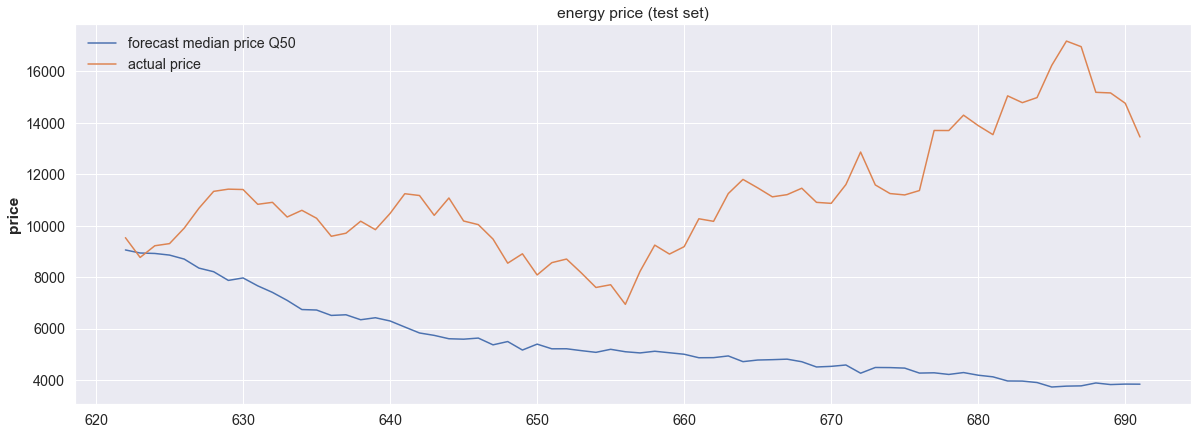

In [178]:
#plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "time", y = "Q50", data = dfY, palette="coolwarm")
sns.lineplot(x = "time", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast median price Q50", "actual price"])
p.set_ylabel("price")
p.set_xlabel("")
p.set_title("energy price (test set)");